# Chapter 9 - Probabilistic models for Time Series

In [ ]:
import numpy as np


%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext lab_black

: 

## Prophet

We can download the daily Yahoo stock history from 2001 to 2021 in `pandas-datareader` as follows:

In [21]:
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
from datetime import datetime

yahoo_data = DataReader("JPM", "yahoo", datetime(2001, 6, 1), datetime(2020, 2, 20))
yahoo_df = yahoo_data["Adj Close"].to_frame().reset_index("Date")

yahoo_df.head()

,Date,Adj Close
0,2001-06-01,26.190706
1,2001-06-04,26.517513
2,2001-06-05,25.981804
3,2001-06-06,25.092522
4,2001-06-07,24.444324


Note the lack of weekends and holidays in the original dataset would be causing a mismatch. Here we fix this:

In [22]:
yahoo_df.set_index("Date", inplace=True)
yahoo_all_dates_df = yahoo_df.resample("D").last()
yahoo_all_dates_df.head()

,Adj Close
Date,
2001-06-01,26.190706
2001-06-02,NaN
2001-06-03,NaN
2001-06-04,26.517513
2001-06-05,25.981804


In [23]:
yahoo_all_dates_df.ffill(inplace=True)
yahoo_all_dates_df.head()

,Adj Close
Date,
2001-06-01,26.190706
2001-06-02,26.190706
2001-06-03,26.190706
2001-06-04,26.517513
2001-06-05,25.981804


In [25]:
yahoo_all_dates_df.reset_index(inplace=True)

<AxesSubplot:xlabel='Date'>

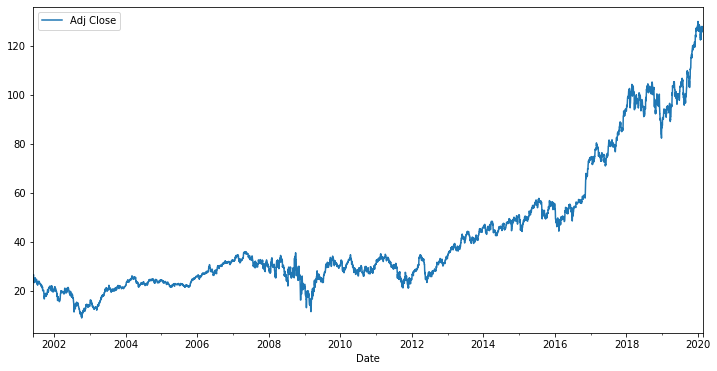

In [26]:
yahoo_all_dates_df.plot(x="Date", figsize=(12, 6))

This gives us a pandas DataFrame with two columns, the adjusted daily closing
value and the date. Let's quickly check the datatypes of these two columns:

In [32]:
yahoo_all_dates_df.dtypes

Date         datetime64[ns]
Adj Close           float64
dtype: object

In [36]:
nobs = 365 * 2
train = yahoo_all_dates_df[:-nobs]
test = yahoo_all_dates_df[-nobs:]

In [37]:
print(
    f"Length of dataframe: {len(yahoo_all_dates_df)}\n"
    f"Length of train set: {len(train)}\n"
    f"Length of test set: {len(test)}"
)

Length of dataframe: 6839
Length of train set: 6109
Length of test set: 730


In [38]:
from prophet import Prophet

In [39]:
forecaster = Prophet()
forecaster.fit(train.rename(columns={"Date": "ds", "Adj Close": "y"}))

10:51:22 - cmdstanpy - INFO - Chain [1] start processing
10:51:25 - cmdstanpy - INFO - Chain [1] done processing


We have to rename our columns ds and y in order to stick to the Prophet conventions. We have a trained Prophet model now.  

We'll then create a new DataFrame that will have future dates. We'll be able to stick this DataFrame into the predict() method of the Prophet model:

In [40]:
future = forecaster.make_future_dataframe(periods=nobs, freq="D")

The forecast is calling the `predict()` method with this new DataFrame:

In [41]:
forecast = forecaster.predict(future)

In [42]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2001-06-01,23.330475,18.510312,27.895263,23.330475,23.330475,-0.076615,-0.076615,-0.076615,0.010102,0.010102,0.010102,-0.086718,-0.086718,-0.086718,0.0,0.0,0.0,23.253860
1,2001-06-02,23.313264,18.478954,27.671948,23.313264,23.313264,-0.081071,-0.081071,-0.081071,-0.000161,-0.000161,-0.000161,-0.080910,-0.080910,-0.080910,0.0,0.0,0.0,23.232193
2,2001-06-03,23.296052,18.490335,27.990077,23.296052,23.296052,-0.086666,-0.086666,-0.086666,-0.010319,-0.010319,-0.010319,-0.076347,-0.076347,-0.076347,0.0,0.0,0.0,23.209386
3,2001-06-04,23.278840,18.439613,27.873325,23.278840,23.278840,-0.109342,-0.109342,-0.109342,-0.035637,-0.035637,-0.035637,-0.073705,-0.073705,-0.073705,0.0,0.0,0.0,23.169499
4,2001-06-05,23.261629,18.457050,27.921907,23.261629,23.261629,-0.085713,-0.085713,-0.085713,-0.012126,-0.012126,-0.012126,-0.073587,-0.073587,-0.073587,0.0,0.0,0.0,23.175916


In [43]:
forecast.ds.describe()

/var/folders/63/m20qx7592pb4b2zvqmy711qc0000gn/T/ipykernel_28591/2228427570.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  forecast.ds.describe()


count                    6839
unique                   6839
top       2001-06-01 00:00:00
freq                        1
first     2001-06-01 00:00:00
last      2020-02-20 00:00:00
Name: ds, dtype: object

The forecast DataFrame contains the upper and lower confidence intervals
alongside the forecast. The ds columns is the date corresponding to the forecast.  
Let's plot the forecasts against the actual data:

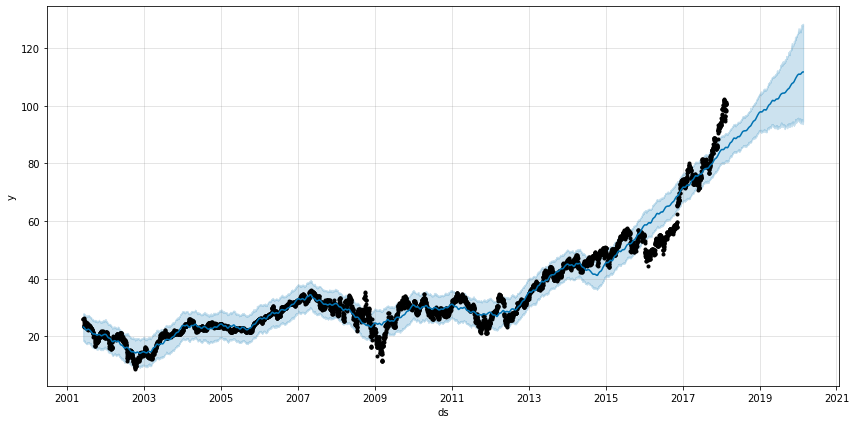

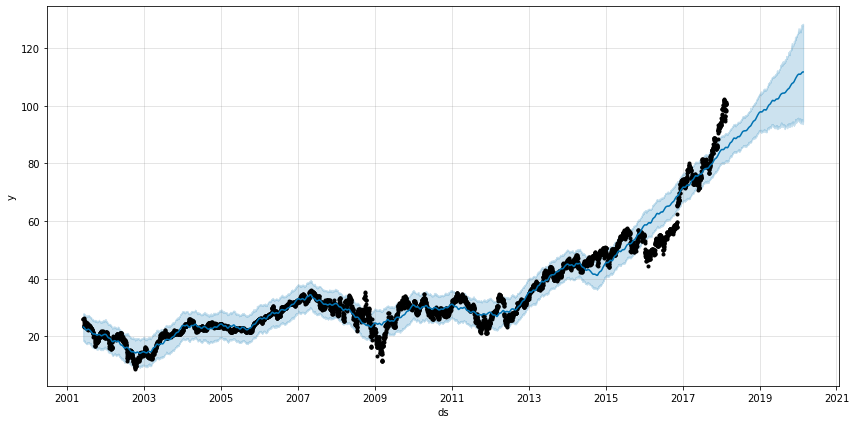

In [44]:
forecaster.plot(forecast, figsize=(12, 6))

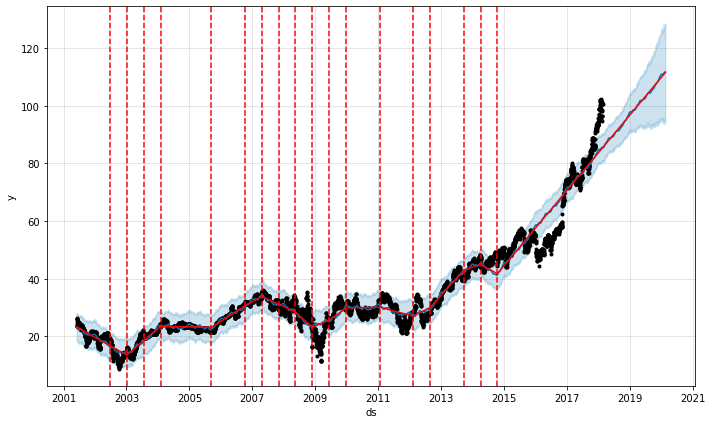

In [45]:
from prophet.plot import add_changepoints_to_plot

fig1 = forecaster.plot(forecast)

# viewing the points in time where the trajectory of the stock index changed
a = add_changepoints_to_plot(
    fig1.gca(),
    forecaster,
    forecast,
    threshold=0.001,
)

We can inspect the forecasts by looking at the DataFrame:

In [46]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2001-06-01,23.330475,18.510312,27.895263,23.330475,23.330475,-0.076615,-0.076615,-0.076615,0.010102,0.010102,0.010102,-0.086718,-0.086718,-0.086718,0.0,0.0,0.0,23.253860
1,2001-06-02,23.313264,18.478954,27.671948,23.313264,23.313264,-0.081071,-0.081071,-0.081071,-0.000161,-0.000161,-0.000161,-0.080910,-0.080910,-0.080910,0.0,0.0,0.0,23.232193
2,2001-06-03,23.296052,18.490335,27.990077,23.296052,23.296052,-0.086666,-0.086666,-0.086666,-0.010319,-0.010319,-0.010319,-0.076347,-0.076347,-0.076347,0.0,0.0,0.0,23.209386
3,2001-06-04,23.278840,18.439613,27.873325,23.278840,23.278840,-0.109342,-0.109342,-0.109342,-0.035637,-0.035637,-0.035637,-0.073705,-0.073705,-0.073705,0.0,0.0,0.0,23.169499
4,2001-06-05,23.261629,18.457050,27.921907,23.261629,23.261629,-0.085713,-0.085713,-0.085713,-0.012126,-0.012126,-0.012126,-0.073587,-0.073587,-0.073587,0.0,0.0,0.0,23.175916


## Comparing predictions to actual values

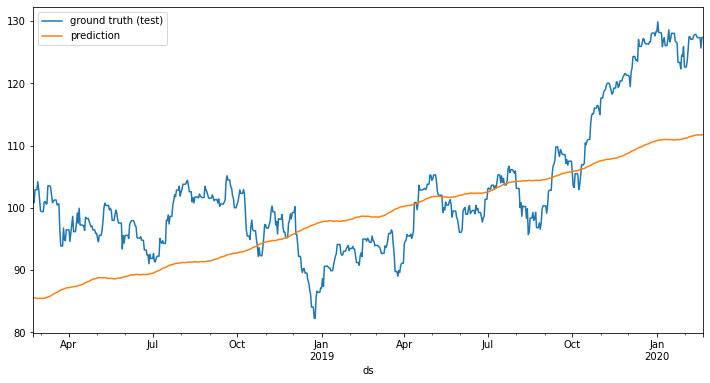

In [47]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
test.rename(columns={"Date": "ds", "Adj Close": "y"}).set_index(keys=["ds"])["y"].plot()

forecast.set_index(keys=["ds"]).iloc[-nobs:, :]["yhat"].plot()


ax.legend(
    [
        "ground truth (test)",
        "prediction",
    ]
)

## Markov Switching Model

In [48]:
# from statsmodels.tsa.regime_switching.tests.test_markov_autoregression
import statsmodels.api as sm
import seaborn as sn
import pandas as pd

We'll use a dataset with statsmodels in this example. This is based on the
statsmodels tutorial on Markov switching autoregression models. We can get the
dataset from the Stata Press publishing house on their website:

In [49]:
dta = pd.read_stata("https://www.stata-press.com/data/r14/rgnp.dta").iloc[1:]
dta.index = pd.DatetimeIndex(dta.date, freq="QS")
dta_hamilton = dta.rgnp

This gives us a pandas series of the RGNP, and the index annotates the dates. Let's
quickly plot this:

<AxesSubplot:title={'center':'Growth rate of RGNP'}, xlabel='date'>

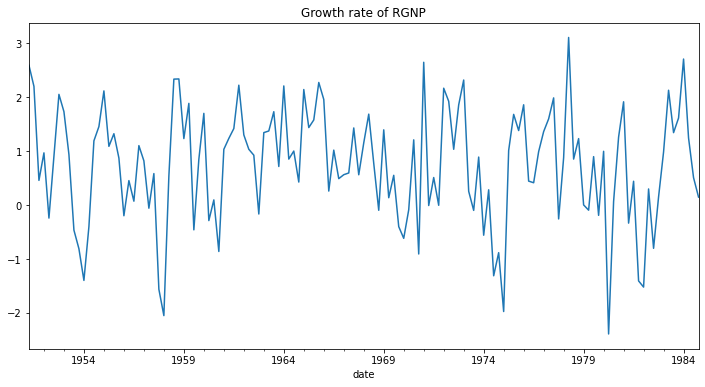

In [50]:
dta_hamilton.plot(title="Growth rate of RGNP", figsize=(12, 6))

We'll model domestic recessions and expansions. The model will include transition
probabilities between these two regimes and predict probabilities of expansion or
recession at each time point.

Let's fit the 4th order Markov switching model. We'll specify two regimes:


In [51]:
mod_hamilton = sm.tsa.MarkovAutoregression(
    dta_hamilton, k_regimes=2, order=4, switching_ar=False
)
res_hamilton = mod_hamilton.fit()

We now have the model fitted via maximum likelihood estimation to the RGNP data.  
We've set `switching_ar=False` because the statsmodels implementation defaults to
switching autoregressive coefficients.  
Let's have a look at the statsmodels model summary:

In [52]:
print(res_hamilton.summary())

                         Markov Switching Model Results                         
Dep. Variable:                     rgnp   No. Observations:                  131
Model:             MarkovAutoregression   Log Likelihood                -181.263
Date:                  Tue, 19 Jul 2022   AIC                            380.527
Time:                          10:53:31   BIC                            406.404
Sample:                      04-01-1951   HQIC                           391.042
                           - 10-01-1984                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3588      0.265     -1.356      0.175      -0.877       0.160
                             Regime 

The output array([ 4.07604793, 10.4258926 ]) is in financial quarters. Therefore,
a recession is expected to take about four quarters (1 year) and an expansion 10
quarters (two and a half years).

In [53]:
res_hamilton.expected_durations

array([ 4.07604746, 10.42589382])

In [54]:
from pandas_datareader.data import DataReader
from datetime import datetime

usrec = DataReader(
    "USREC", "fred", start=datetime(1947, 1, 1), end=datetime(2013, 4, 1)
)

In [55]:
usrec.value_counts()

USREC
0        674
1        122
dtype: int64

In [56]:
usrec.head()

,USREC
DATE,
1947-01-01,0
1947-02-01,0
1947-03-01,0
1947-04-01,0
1947-05-01,0


In [57]:
import matplotlib.pyplot as plt

This gives us actual recession data against model predictions:

[(-6484.0, 5387.0),
 (0.0, 1.0),
 Text(0.5, 1.0, 'Filtered probability of recession')]

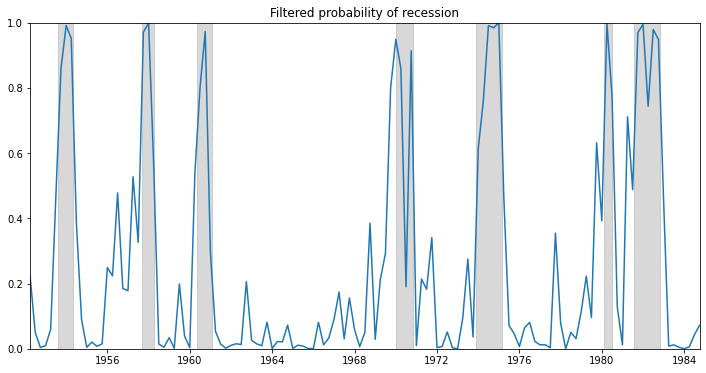

In [58]:
_, ax = plt.subplots(1, figsize=(12, 6))

ax.plot(res_hamilton.filtered_marginal_probabilities[0])
ax.fill_between(usrec.index, 0, 1, where=usrec["USREC"].values, color="gray", alpha=0.3)
ax.set(
    xlim=(dta_hamilton.index[4], dta_hamilton.index[-1]),
    ylim=(0, 1),
    title="Filtered probability of recession",
)

## Fuzzy Time-Series

In [59]:
from pyFTS.data import NASDAQ, SP500

datasets = {"SP500": SP500.get_data()[11500:16000], "NASDAQ": NASDAQ.get_data()}

In [60]:
datasets

{'SP500': array([ 585.48001125,  584.36749275,  581.494995  , ..., 1698.39001475,
        1706.5300295 , 1706.985016  ]),
 'NASDAQ': array([2373.61, 2434.87, 2597.32, ..., 5215.29, 5226.75, 5210.88])}

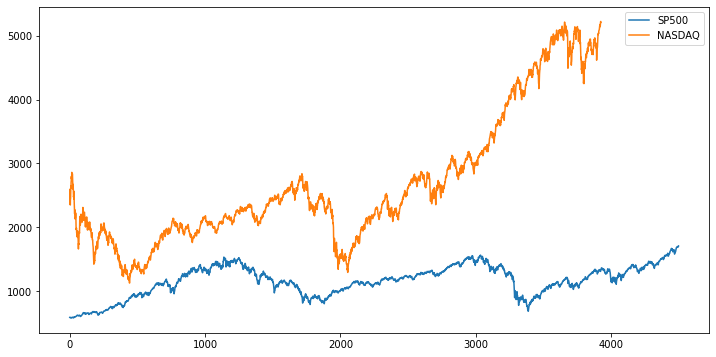

In [61]:
fig, ax = plt.subplots(figsize=[12, 6])
plt.plot(datasets["SP500"])
plt.plot(datasets["NASDAQ"])
plt.legend(["SP500", "NASDAQ"])

Both datasets, the entries in our datasets dictionary, are vectors of roughly 4,000
scalar values. We'll take about 50% of these points for training, and we'll set this as a
constant:

In [62]:
train_split = 2000

The model assumes a stationary process, so we'll need to preprocess our time-series
by temporal differencing as discussed in Chapter 2, Exploratory Time-Series Analysis
with Time-Series.  
We'll define a first-order differencing operation for preprocessing:

In [63]:
from pyFTS.common import Transformations

tdiff = Transformations.Differential(1)

Let's plot our time-series and the transformation:

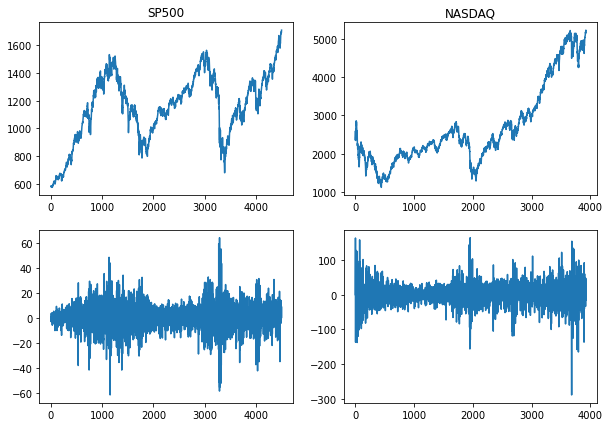

In [64]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))
for count, (dataset_name, dataset) in enumerate(datasets.items()):
    dataset_diff = tdiff.apply(dataset)
    ax[0][count].plot(dataset)
    ax[1][count].plot(dataset_diff)
    ax[0][count].set_title(dataset_name)

The next step is training our models for the two transformed (differenced) timeseries:

In [66]:
from pyFTS.models import song
from pyFTS.partitioners import Grid

models = {}
for count, (dataset_name, dataset) in enumerate(datasets.items()):
    partitioner_diff = Grid.GridPartitioner(
        data=dataset, npart=15, transformation=tdiff
    )
    model = song.ConventionalFTS(partitioner=partitioner_diff)
    model.name = dataset_name
    model.append_transformation(tdiff)
    model.fit(dataset[:train_split], order=1)
    models[dataset_name] = model

In [70]:
print(np.shape(dataset))
np.shape(dataset[train_split : train_split + 200])

(3926,)


(200,)

We iterate over the datasets and train a separate model for each, which we save into
a dictionary, models. The training consists of extracting relations from the training
set.  
As part of the model training, the preprocessed time-series is quantized as discussed
in the theory section on fuzzy time-series models of this chapter.  
We can plot our forecasts from the two models:

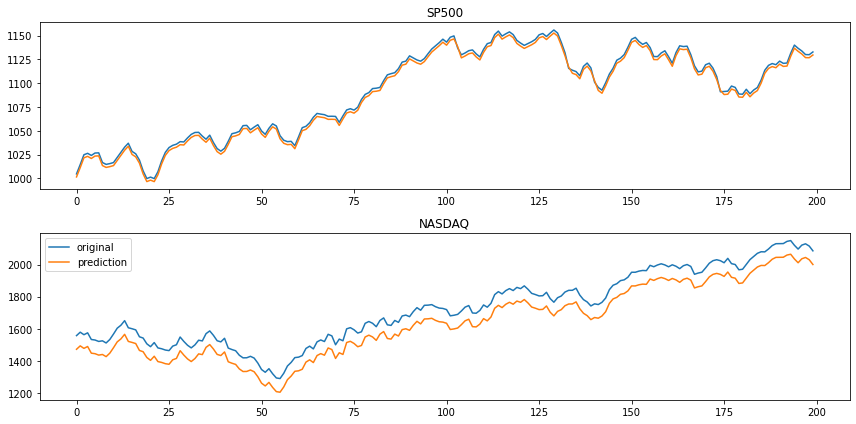

In [68]:
_, ax = plt.subplots(nrows=2, ncols=1, figsize=[12, 6])
for count, (dataset_name, dataset) in enumerate(datasets.items()):
    ax[count].plot(dataset[train_split : train_split + 200])
    model = models[dataset_name]
    forecasts = model.predict(dataset[train_split : train_split + 200], steps_ahead=1)
    ax[count].plot(forecasts)
    ax[count].set_title(dataset_name)
    plt.legend(["original", "prediction"])
plt.tight_layout()

Time series data tend to be correlated in time, and exhibit a significant autocorrelation. In this case, that means that the index at time “t+1” is quite likely close to the index at time “t”. As illustrated in the above figure, what the model is actually doing is that when predicting the value at time “t+1”, it simply uses the value at time “t” as its prediction (often referred to as the persistence model).

-15
-14
-13
-12
-11
-10
-9
-8
-7
-6
-5
-4
-3
-2
-1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
SP500: [0.8343261246679823, 0.8426854662001859, 0.853166694244784, 0.8637579119205832, 0.8727620467577439, 0.8816701090941946, 0.8925208997949858, 0.9038589282804272, 0.914429619214645, 0.9250978593351479, 0.9368124269540585, 0.9501741884371083, 0.9639767404141812, 0.9781034653938041, 0.9922705705929171, 0.999898148455279, 0.9922705705929171, 0.9781034653938041, 0.9639767404141812, 0.9501741884371083, 0.9368124269540585, 0.9250978593351479, 0.914429619214645, 0.9038589282804272, 0.8925208997949858, 0.8816701090941946, 0.8727620467577439, 0.8637579119205832, 0.853166694244784, 0.8426854662001859]
-15
-14
-13
-12
-11
-10
-9
-8
-7
-6
-5
-4
-3
-2
-1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
NASDAQ: [0.8940693017356707, 0.9001430288714998, 0.9056219992548975, 0.9121597142910607, 0.9186348272405327, 0.9252268104767799, 0.9315918437710276, 0.9387315955997398, 0.9461268125859357, 0.954599158027644, 0.963555091454475

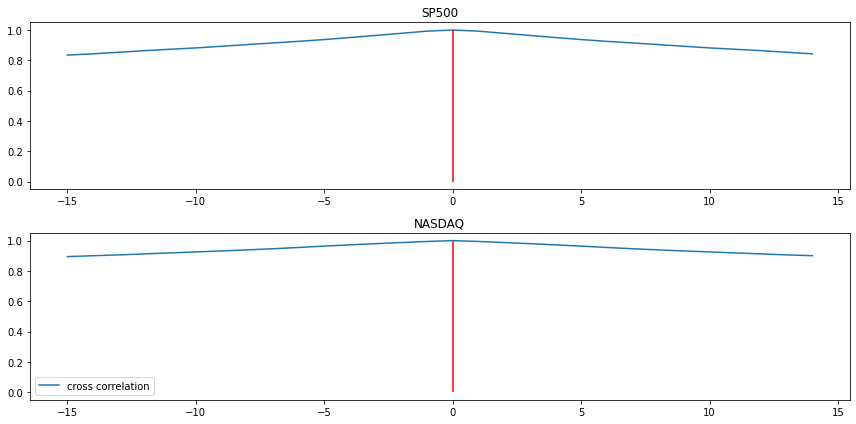

In [89]:
def calculate_cross_correlation(dataset1, dataset2, time_lag=15):
    """Calculate the cross correlation between two datasets"""
    if time_lag < 0:
        return np.corrcoef(dataset1[-time_lag:], dataset2[:time_lag])[0, 1]
    if time_lag == 0:
        return np.corrcoef(dataset1, dataset2)[0, 1]
    return np.corrcoef(dataset1[time_lag:], dataset2[:-time_lag])[0, 1]


_, ax = plt.subplots(nrows=2, ncols=1, figsize=[12, 6])
for count, (dataset_name, dataset) in enumerate(datasets.items()):
    ground_truth = dataset[train_split : train_split + 200]
    forecasts = models[dataset_name].predict(ground_truth, steps_ahead=1)
    cross_correlation = []
    for time_lag in range(-15, 15):
        print(time_lag)
        cross_correlation.append(
            calculate_cross_correlation(ground_truth, forecasts, time_lag)
        )

    print(f"{dataset_name}: {cross_correlation}")
    x_axis = np.arange(-15, 15)
    ax[count].plot(x_axis, cross_correlation)
    ax[count].vlines(x_axis[np.argmax(cross_correlation)], 0, 1, color="red")
    ax[count].set_title(dataset_name)
    plt.legend(["cross correlation"])
plt.tight_layout()
plt.show()

Looking at these charts, the predictions look quite promising, but let's look at some
hard numbers!  
PyFTS has a convenience function to extract RMSE, MAPE, and finally, Theil's U, a
measure of correlation. We introduced these measures in Chapter 2, Exploratory Time-
Series Analysis with Time-Series.

In [76]:
from pyFTS.benchmarks import Measures

rows = []
for count, (dataset_name, dataset) in enumerate(datasets.items()):
    row = [dataset_name]
    test = dataset[train_split : train_split + 200]
    model = models[dataset_name]
    row.extend(Measures.get_point_statistics(test, model))
    rows.append(row)
pd.DataFrame(rows, columns=["Dataset", "RMSE", "MAPE", "Theil's U"]).set_index(
    "Dataset"
)

,RMSE,MAPE,Theil's U
Dataset,,,
SP500,6.76,0.52,1.22
NASDAQ,90.85,5.14,3.79


## Bayesian Structural Time-Series Modelling

In [1]:
import pandas as pd
from causalimpact import CausalImpact

data = pd.read_csv("https://raw.githubusercontent.com/WillianFuks/tfcausalimpact/master/tests/fixtures/volks_data.csv", header=0, sep=' ',
index_col='Date', parse_dates=True)

ModuleNotFoundError: No module named 'causalimpact'